<a href="https://www.kaggle.com/code/hoale2908/healthcare-insurance-eda-regression?scriptVersionId=216288580" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://www.securitymagazine.com/ext/resources/images/healthcare-banner.jpg?1607104673)

# Introduction

Predicting healthcare costs for individuals using accurate prediction models is important for various stakeholders beyond health insurers, and for various purposes. A few notable benefits of accurately predicting healthcare costs for insurance companies are determining fair and competitive premium rates, personalizing insurance plans, and optimizing resource allocation.

The dataset contains demographic and health information and healthcare cost of 1,338 patients. This notebook aims to find out how healthcare costs are driven by these variables by visualizing their relationships, and developing models to predict healthcare costs.


**Table of content:**
1. Data Preparation
2. Exploratory Data Analysis
3. Model Development - Multiple Linear Regression

# 1. Data Preparation

In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_palette('magma')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
df = pd.read_csv('/kaggle/input/healthcare-insurance/insurance.csv')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
# Check for duplicates and drop them if any
print('Number of duplicates: ',df.duplicated().sum())
if df.duplicated().sum()>0:
    df = df.drop(df[df.duplicated()==1].index, axis=0)
print('Removed duplicates.')

Number of duplicates:  1
Removed duplicates.


In [3]:
# Check for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
# Truncate BMI and charges
df['bmi'] = np.trunc(10 * df['bmi']) / 10
df['charges'] = np.trunc(100 * df['charges']) / 100
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.7,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.8,0,no,northwest,3866.85


___

# 2. Exploratory Data Analysis

## Distribution of Categorical Variables

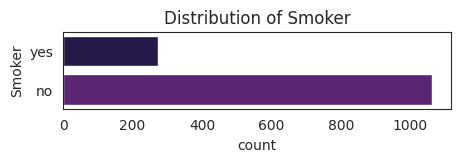

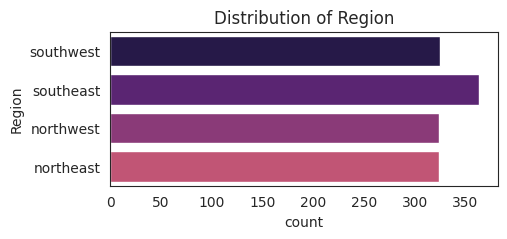

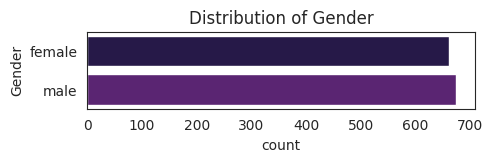

In [5]:
plt.figure(figsize=(5,1))
sns.countplot(df,y='smoker')
plt.title('Distribution of Smoker')
plt.ylabel('Smoker')

plt.figure(figsize=(5,2))
sns.countplot(df,y='region')
plt.title('Distribution of Region')
plt.ylabel('Region')

plt.figure(figsize=(5,1))
sns.countplot(df,y='sex')
plt.title('Distribution of Gender')
plt.ylabel('Gender')
plt.show()

## Distribution of Numerical Variables and Linear Relationships

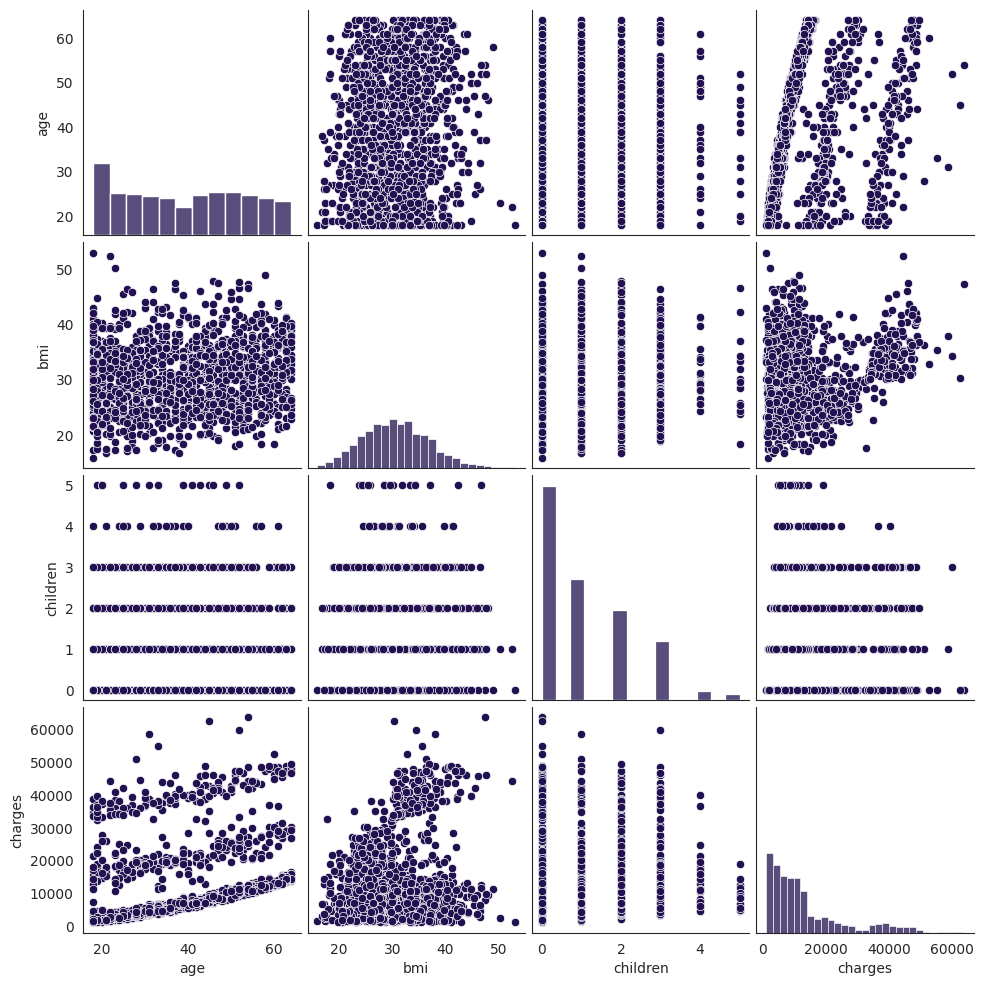

In [6]:
sns.pairplot(df)
plt.show()

Charges has a low correlation with Age, BMI, and Number of children, respectively. We can calculate the correlation among them.

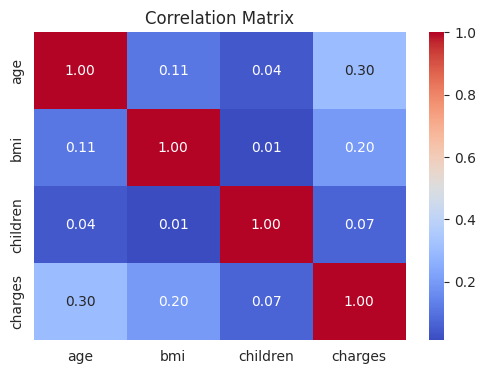

In [7]:
# Correlation matrix
plt.figure(figsize=(6, 4))
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Relationship between Charges and Categorical Variables

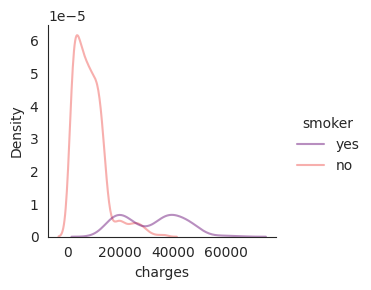

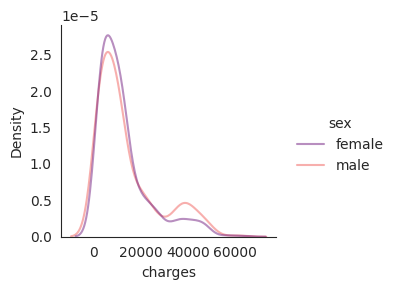

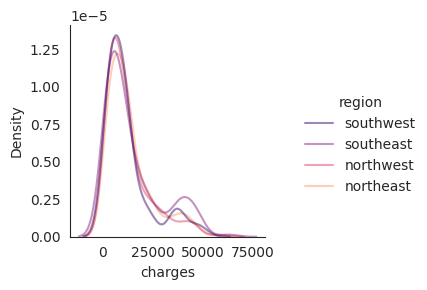

In [8]:
sns.displot(x="charges", hue="smoker", kind='kde',
            alpha=.5, palette="magma", height=3,
            data=df)

sns.displot(x="charges", hue="sex", kind='kde',
            alpha=.5, palette="magma", height=3,
            data=df)

sns.displot(x="charges", hue="region", kind='kde',
            alpha=.5, palette="magma", height=3,
            data=df)
plt.show()

Smoking status has an impact on Charges, while Region and Sex do not.

## Relationship between Charges and Multiple Variables

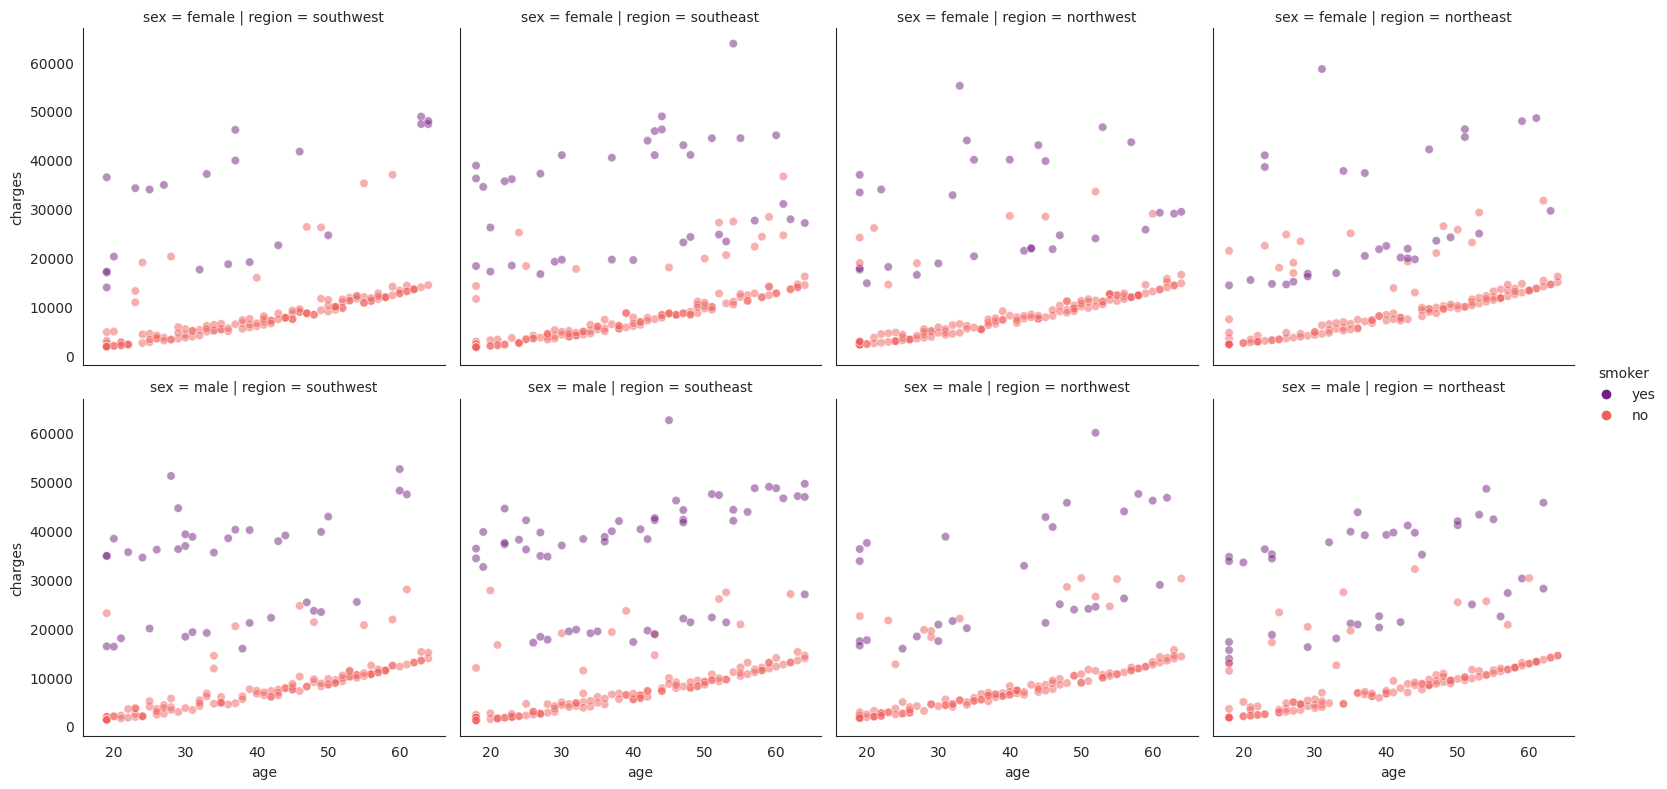

In [9]:
sns.relplot(data=df,x='age',y='charges',
           hue='smoker',row='sex', col='region',
           alpha=0.5, palette='magma', height=4)
plt.show()

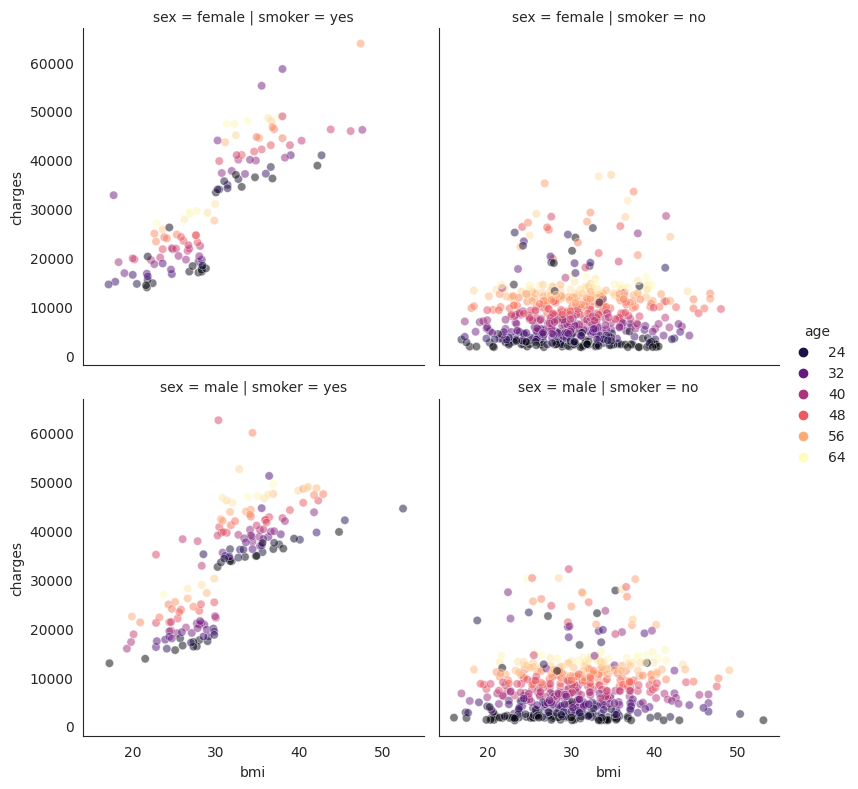

In [10]:
sns.relplot(data=df,x='bmi',y='charges',
           hue='age',row='sex', col='smoker',
           alpha=0.5, palette='magma', height=4)
plt.show()

Smoking and BMI seem to have complement effect. For smokers, higher BMI leads to higher Charges. For non-smokers, Charges stay relatively low for all levels of BMI.

## Summary of insight
- Smoking affects healthcare costs, with smokers have higher healthcare costs than non-smokers.
- Among smokers, people with higher BMI incur higher healthcare costs.
- Age affects healthcare costs, with older people have higher costs than younger people.
- People with more children consist of mainly non-smokers. The causal relationship between the number of children and smoking status, or vice versa, cannot be determined through this dataset.
- Location and gender do not significantly affect healthcare costs.

The above findings are good suggestions for choosing independent variables in a healthcare cost prediciton model. Particularly, we can expect that Smoking status and BMI play an important role in predicting healthcare costs.

___

# 3. Model Development

As a baseline model, we will use Smoker, Age and BMI as indipendent variables.

In [11]:
# Define independent and dependent variables
df.replace({'smoker': {'yes': 1, 'no': 0}}, inplace=True)
x = df[['smoker', 'age', 'bmi']].values
y = np.array(df['charges'])

In [12]:
# Create training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

## Multiple Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
model_MLR = LinearRegression().fit(x_train, y_train)
y_pred_MLR = model_MLR.predict(x_test)

r_sq = model_MLR.score(x, y)
print(f"Coefficient of determination: {r_sq}")

print(f"Intercept: {model_MLR.intercept_}")

print(f"Coefficients: {model_MLR.coef_}")

Coefficient of determination: 0.7470281763587638
Intercept: -10769.654425041617
Coefficients: [23702.26154321   250.1284211    304.13776941]


In [14]:
smoker=0
age=20
bmi=30
cost = round(model_MLR.intercept_ + smoker*model_MLR.coef_[0] + age*model_MLR.coef_[1] + bmi*model_MLR.coef_[2],2)

if smoker==0:
    print(f'A {age}-year-old non-smoker with BMI of {bmi} will likely incur ${cost} for healthcare insurance.')
else:
    print(f'A {age}-year-old smoker with BMI of {bmi} will likely incur ${cost} for healthcare insurance.')
    

A 20-year-old non-smoker with BMI of 30 will likely incur $3357.05 for healthcare insurance.


The MLR model can **only explain 75%** of the cases, so it is not very accurate.

Since Smoking and BMI are likely correlated, we can try fitting a polynomial regression model.

## Polynomial Regression 

In [15]:
from sklearn.preprocessing import PolynomialFeatures
x_train_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_train)
model_PR = LinearRegression().fit(x_train_poly, y_train)

x_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
r_sq2 = model_PR.score(x_poly, y)
print(f"Coefficient of determination: {r_sq2}")
print(f"Intercept: {model_PR.intercept_}")
print(f"Coefficients: {model_PR.coef_}")

Coefficient of determination: 0.8384596551762704
Intercept: -6044.03137971318
Coefficients: [-1.05745401e+04  6.60928705e+01  5.21729101e+02 -1.05745401e+04
  1.95138161e+01  1.44168187e+03  1.78542459e+00  1.53447523e+00
 -9.35711839e+00]


The $R^2$ increased to 83.8%.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
x_train_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x_train)
model_PR3 = LinearRegression().fit(x_train_poly, y_train)

x_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x)
r_sq3 = model_PR3.score(x_poly, y)
print(f"Coefficient of determination: {r_sq3}")
print(f"Intercept: {model_PR3.intercept_}")
print(f"Coefficients: {model_PR3.coef_}")

Coefficient of determination: 0.8410189397596138
Intercept: 25609.667306455973
Coefficients: [-8.82017925e+03  1.44747747e+02 -2.69938606e+03 -8.82017925e+03
 -1.51725305e+01  9.31280521e+02  1.86820724e+00 -1.78902617e+00
  9.34367872e+01 -8.82017925e+03 -1.51725305e+01  9.31280521e+02
 -2.29772160e+00  7.35459474e+00 -1.07627356e+01 -7.96756180e-03
  4.11040424e-02 -4.27396058e-02 -1.00382747e+00]


Increasing the degree from 2 to 3 improved the model's $R^2$ from 83.8% to 84.1% while making it much more complicated.